# Práctica Final
**Autor: Jorge Vázquez Pérez**

In [1]:
#%pip install qiskit
#%pip install graphviz

from qiskit import QuantumCircuit, transpile, execute
from qiskit_aer import Aer
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.visualization import plot_gate_map

from qiskit_ibm_provider import IBMProvider
import qiskit.tools.jupyter

IBMProvider.save_account('368ce8e3d58876f8744c71270f2727fd9883b04d75ad646fa5f7345d0b9dede6f06cdc12ebf7e0d0db8a2f0881369da230f432512437401e11ae29dd202b9561', overwrite=True)

%qiskit_version_table

En primer lugar, comenzamos construyendo el circuito deseado, este circuito se corresponde con el circuíto del algoritmo de Berstein-Varizani de 5 qubits.

/home/jorge.vazquez.perez/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


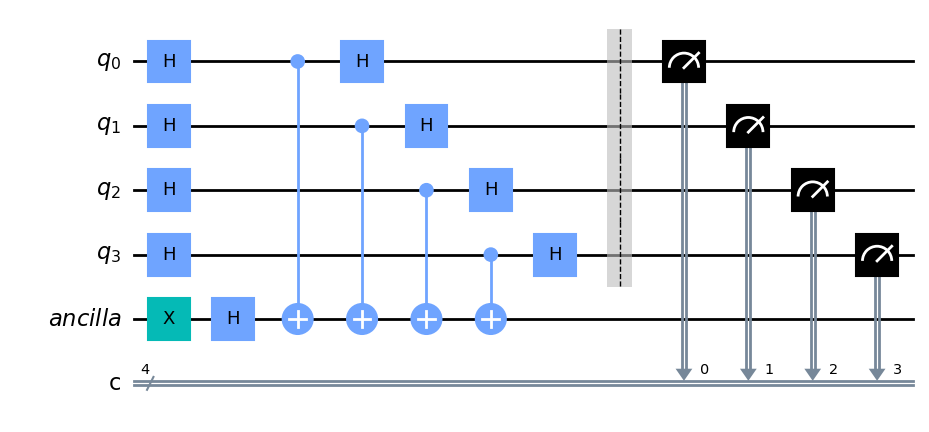

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
 
qr = QuantumRegister(4, 'q')
anc = QuantumRegister(1, 'ancilla')
cr = ClassicalRegister(4, 'c')
qc = QuantumCircuit(qr, anc, cr)
 
qc.x(anc[0])
qc.h(anc[0])
qc.h(qr[0:4])
qc.cx(qr[0:4], anc[0])
qc.h(qr[0:4])
qc.barrier(qr)
qc.measure(qr, cr)
 
qc.draw('mpl')

Ahora, ejecutamos el circuíto simulando el comportamiento ideal con Aer. Seleccionaremos el backend por defecto de Aer, haciendo que él automáticamente seleccione el más adecuado.

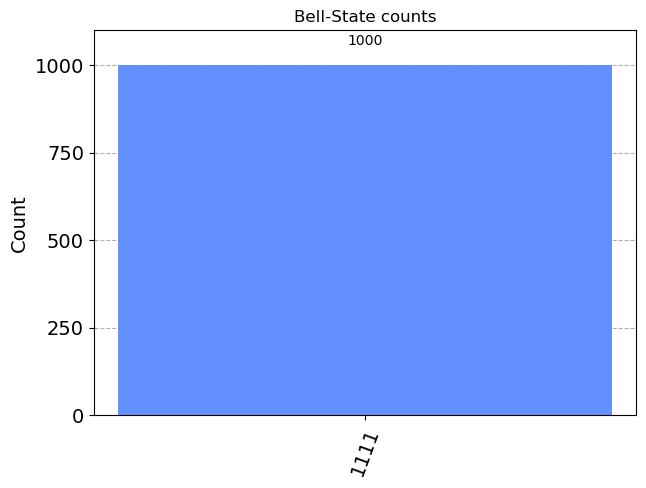

In [3]:
shots=1000

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator') # automatic simulation method
tqc = transpile(qc, simulator)

# Run and get counts
counts = execute(tqc, simulator, shots=shots).result().get_counts()
display(plot_histogram(counts, title='Berstein-Vazirani Counts'))

Ahora, ejecutamos en el computador cuántico real con menos carga de trabajo de IBM.

In [9]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import least_busy

provider = IBMProvider()
shots = 1000

# Transpile for real quantum computer
devices = provider.backends(simulator=False, operational=True)
real_backend = least_busy(devices)

noise_model_real = NoiseModel.from_backend(real_backend)
bases_gates_real = real_backend.basis_gates
coupling_map_real = real_backend.coupling_map
noise_simulator_backend = Aer.get_backend("aer_simulator")

tqc = transpile(qc, real_backend)

# Run and get counts
counts_real = execute(tqc, noise_simulator_backend, noise_model=noise_model_real, basis_gates=bases_gates_real, coupling_map=coupling_map_real, shots=shots).result().get_counts()
display(plot_histogram(counts_real, title='Circuit counts'))

Vemos como a diferencia del caso ideal, la distribución de probabilidad no se acumula únicamente en el resultado $|1111\rangle$. Ahora, apliquemos diferentes técnicas de mitigación y supresión de errores.

/home/jorge.vazquez.perez/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


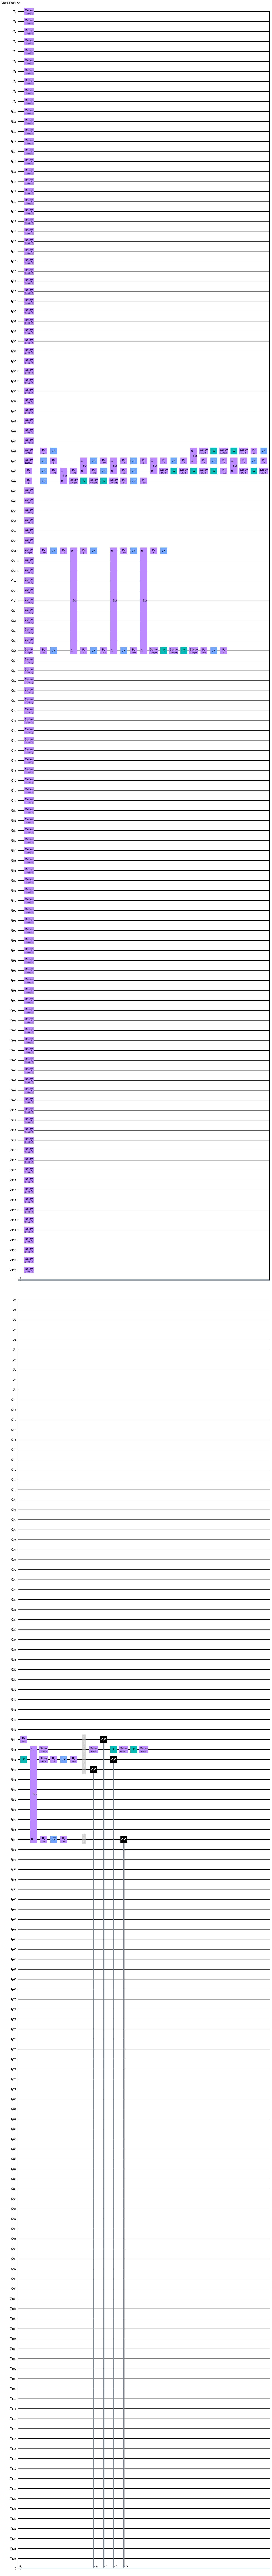

In [ ]:
from qiskit.transpiler import InstructionDurations
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling

#Obtengo la duración de sus intrucciones y las restricciones temporales
durations = InstructionDurations.from_backend(real_backend)
constraints = real_backend.configuration().timing_constraints

dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence, pulse_alignment=constraints['pulse_alignment'])])

#Hay que aplicarlo al circuito transpilado
qc_dd = pm.run(tqc)
qc_dd.draw("mpl")

In [ ]:
tqc = transpile(qc_dd, real_backend)
counts_dd = execute(tqc, noise_simulator_backend, noise_model=noise_model_real, basis_gates=bases_gates_real, coupling_map=coupling_map_real, shots=shots).result().get_counts()

plot_distribution([counts_real, counts_dd],legend=['real', 'DD'], bar_labels=False)

NameError: name 'counts_real' is not defined